# detect swr 

### with ripple detection from:

https://github.com/Eden-Kramer-Lab/ripple_detection

## import packages

In [2]:
# data managment and math functions
import pandas as pd
import numpy as np
import math

import time

# import neuroseries as nts

# plotting
from matplotlib import pyplot as plt

# scipy
import scipy.io
import scipy.signal
from scipy import stats
from scipy.signal import hilbert,detrend
from scipy.ndimage import gaussian_filter1d

# for loading files
import h5py
import sys,os
import glob
import pickle

# parallel processing
import multiprocessing
from joblib import Parallel, delayed

# ripple detector
from ripple_detection import Kay_ripple_detector, Karlsson_ripple_detector, filter_ripple_band

from ripple_detection.core import gaussian_smooth, get_envelope

# Continuous Wavelet Transform
import obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt

## set up plotting defaults

In [3]:
plt.style.use('dark_background')

params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

plt.rcParams.update({'font.size': 13})
%config InlineBackend.figure_format = 'retina'

In [81]:
def loadXML(path):
    """
    path should be the folder session containing the XML file
    Function returns :
        1. the number of channels
        2. the sampling frequency of the dat file or the eeg file depending of what is present in the folder
            eeg file first if both are present or both are absent
        3. the mappings shanks to channels as a dict
    Args:
        path : string
    Returns:
        int, int, dict
    """
    if not os.path.exists(path):
        print("The path "+path+" doesn't exist; Exiting ...")
        sys.exit()
    listdir = os.listdir(path)
    xmlfiles = [f for f in listdir if f.endswith('.xml')]
    if not len(xmlfiles):
        print("Folder contains no xml files; Exiting ...")
        sys.exit()
    new_path = os.path.join(path, xmlfiles[0])

    from xml.dom import minidom
    xmldoc = minidom.parse(new_path)
    nChannels = xmldoc.getElementsByTagName('acquisitionSystem')[0].getElementsByTagName('nChannels')[0].firstChild.data
    fs_dat = xmldoc.getElementsByTagName('acquisitionSystem')[0].getElementsByTagName('samplingRate')[0].firstChild.data
    fs = xmldoc.getElementsByTagName('fieldPotentials')[0].getElementsByTagName('lfpSamplingRate')[0].firstChild.data

    shank_to_channel = {}
    groups = xmldoc.getElementsByTagName('anatomicalDescription')[0].getElementsByTagName('channelGroups')[0].getElementsByTagName('group')
    for i in range(len(groups)):
        shank_to_channel[i] = np.sort([int(child.firstChild.data) for child in groups[i].getElementsByTagName('channel')])
    return int(nChannels), int(fs), shank_to_channel

def loadLFP(path, n_channels=90, channel=64, frequency=1250.0, precision='int16'):
    if type(channel) is not list:
        f = open(path, 'rb')
        startoffile = f.seek(0, 0)
        endoffile = f.seek(0, 2)
        bytes_size = 2
        n_samples = int((endoffile-startoffile)/n_channels/bytes_size)
        duration = n_samples/frequency
        interval = 1/frequency
        f.close()
        with open(path, 'rb') as f:
            data = np.fromfile(f, np.int16).reshape((n_samples, n_channels))[:,channel]
            timestep = np.arange(0, len(data))/frequency
            return data, timestep # nts.Tsd(timestep, data, time_units = 's')
        
    elif type(channel) is list:
        f = open(path, 'rb')
        startoffile = f.seek(0, 0)
        endoffile = f.seek(0, 2)
        bytes_size = 2

        n_samples = int((endoffile-startoffile)/n_channels/bytes_size)
        duration = n_samples/frequency
        f.close()
        with open(path, 'rb') as f:
            data = np.fromfile(f, np.int16).reshape((n_samples, n_channels))[:,channel]
            timestep = np.arange(0, len(data))/frequency
            return data,timestep # nts.TsdFrame(timestep, data, time_units = 's')
        
def load_position(session):
    f = h5py.File(session,'r')
    # load frames [ts x y a s] 
    frames = np.transpose(np.array(f['frames']))
    return pd.DataFrame(frames,columns=['ts', 'x', 'y', 'hd', 'speed'])    

def get_ripple_channel(ripple_times,filtered_lfps,ts,fs):
    channel = []
    peak_amplitude = []

    for ripple in ripple_times.itertuples():
        idx = np.logical_and(ts >= ripple.start_time, ts <= ripple.end_time)
        
        smooth_envelope = gaussian_smooth(get_envelope(filtered_lfps[idx,:]),0.004,fs)
        peaks = np.max(smooth_envelope,axis = 0)
        peak_idx = np.argmax(peaks)

        peak_amplitude.append(peaks[peak_idx])
        channel.append(peak_idx)

    ripple_times['peak_channel'] = channel
    ripple_times['peak_amplitude'] = peak_amplitude
    return ripple_times

def get_phase_amp_freq(sig,fs):
    
    phas = []
    amp = []
    freq = []
    
    for signal in sig.T:
        analytic_signal = hilbert(signal)
        amplitude_envelope = np.abs(analytic_signal)
        phase = np.angle(analytic_signal)
        instantaneous_phase = np.unwrap(phase)
        instantaneous_frequency = gaussian_filter1d((np.diff(instantaneous_phase) / (2.0*np.pi) * fs),
                                                    0.004 * fs, truncate=8, axis=0,mode='constant')
        phas.append(phase)
        amp.append(amplitude_envelope)
        freq.append(instantaneous_frequency)
    
    phas = np.vstack(phas) 
    amp = np.vstack(amp)
    freq = np.vstack(freq) 

    return phas.T,amp.T,freq.T

def get_ripple_freq(ripple_times,freq,dt):
    peak_freq = []
    for ripple in ripple_times.itertuples():
        idx = np.logical_and(dt >= ripple.start_time, dt <= ripple.end_time)
        rip = freq[idx,ripple.peak_channel]
        peak_freq.append(rip[len(rip) // 2])
    ripple_times['peak_freq'] = peak_freq
    return ripple_times

def get_ripple_freq_peaks_method(ripple_times,filtered_lfps,ts,fs,peak_dist=0.0032):
    fqcy = np.zeros((len(ripple_times),1))
    i = 0
    for ripple in ripple_times.itertuples():
        idx = np.logical_and(ts >= ripple.start_time, ts <= ripple.end_time)
        rip = filtered_lfps[idx,ripple.peak_channel]
        # find peaks with a distance of 3.2 ms
        peakIx = scipy.signal.find_peaks(x = -rip, distance = peak_dist//(1/fs), threshold = 0.0)
        peakIx = peakIx[0]
        if (not (peakIx.size == 0)) and (peakIx.size != 1):
            fqcy[i] = fs/np.median(np.diff(peakIx))
        else:
            print("This is something weird now...")
        i += 1
    ripple_times['peak_freq'] = fqcy
    return ripple_times
    
def get_session_path(session):
    f = h5py.File(session,'r')
    return f['session_path'][()].tobytes()[::2].decode()

def get_ripple_maps(ripple_times,ts,lfp,filtered_lfps,phase,amp,freq,fs):
    
    # Initializing variables
    rip = np.zeros((len(ripple_times),151))
    rip_filt = np.zeros((len(ripple_times),151))
    rip_phase = np.zeros((len(ripple_times),151))
    rip_amp = np.zeros((len(ripple_times),151))
    rip_freq = np.zeros((len(ripple_times),151))

    # row index
    ind = np.arange(0,len(lfp),1) 

    i = 0
    for ripple in ripple_times.itertuples():
        # get ripple index
        idx = np.logical_and(ts >= ripple.start_time, ts <= ripple.end_time)
        # find peak of ripple using the smoothed filtered signal
        smooth_envelope = gaussian_smooth(get_envelope(filtered_lfps[idx,int(ripple.peak_channel)]),0.004,fs)
        rip_peak_idx = np.argmax(smooth_envelope)
        # find that peaks location in signal
        middle_idn = ind[idx][rip_peak_idx]
        # create expanded index
        idx = np.arange(middle_idn - 75,middle_idn + 76,1)
        
        # if ripple is the the very beginning or end of session
        if (middle_idn - 75 < 0) or (middle_idn + 76 > len(ind)):
            x = np.zeros(151)
            rip[i] = x
            rip_filt[i] = x
            rip_phase[i] = x
            rip_amp[i] = x
            rip_freq[i] = x
            print('ripple close to edge of session')
        else:
            # pull out expanded index
            rip[i] = lfp[idx,ripple.peak_channel]
            rip_filt[i] = filtered_lfps[idx,ripple.peak_channel]
            rip_phase[i] = phase[idx,ripple.peak_channel]
            rip_amp[i] = amp[idx,ripple.peak_channel]
            rip_freq[i] = freq[idx,ripple.peak_channel]

            i+=1
        
    ripple_maps = {"ripple_map": rip,
            "filtered_map":rip_filt,
            "phase_map":rip_phase,
           "amp_map":rip_amp,
           "freq_map":rip_freq}
    
    return ripple_maps

def normalize(list, range):
    l = np.array(list) 
    a = np.max(l)
    c = np.min(l)
    b = range[1]
    d = range[0]
    m = (b - d) / (a - c)
    pslope = (m * (l - c)) + d
    return pslope

def get_scalogram(sig,fs,padding=100,f_min=150,f_max=250,fig=1,ax=0):
    
    # sample difference
    dt = 1/fs
    # pad signal
    sig_padded = np.pad(sig, (padding, padding), 'linear_ramp')
    # get time stamps
    t = np.linspace(0, dt * len(sig), len(sig))
    # get scalogram
    scalogram = cwt(sig_padded, dt, 8, f_min, f_max)
    # delete padding
    scalogram = np.delete(scalogram, np.s_[1:padding+1], axis=1) 
    scalogram = np.delete(scalogram, np.s_[-(padding+1):-1], axis=1) 
    
    # plot figure
    if fig==1:
        if ax == 0:
            fig = plt.figure()
            ax = fig.add_subplot(111)

        x, y = np.meshgrid(
            t,
            np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

        ax.pcolormesh(x, y, np.abs(scalogram), cmap=obspy_sequential,shading='auto')
        ax.plot(t,normalize(sig,[f_min,f_max]),'k',linewidth=1)
        ax.set_ylabel("Frequency [Hz]")
        ax.set_ylim(f_min, f_max)
        # ax.set_yscale('log')
        if ax == 0:
            plt.show()
    
    return np.abs(scalogram)

In [4]:
def run_all(session):
    
    # get data session path from mat file
    path = get_session_path(session)
    
    # load position data from .mat file
    df = load_position(session)
    
    # load xml which has channel & fs info
    channels,fs,shank = loadXML(path)
    
    # load .lfp
    lfp,ts = loadLFP(glob.glob(path +'\*.lfp')[0], n_channels=channels, channel=np.arange(0,channels,1))

    # interp speed of the animal
    speed = np.interp(ts,df.ts,df.speed)
    speed[np.isnan(speed)] = 0
    
    # detect ripples
    print('detecting ripples')
    ripple_times = Karlsson_ripple_detector(ts, lfp, speed, fs,                       
                            speed_threshold=3.0, minimum_duration=0.02,
                            zscore_threshold=3.0, smoothing_sigma=0.004,
                            close_ripple_threshold=0.0)
    
    # restrict ripples to < 150 ms
    ripple_times['ripple_duration'] = ripple_times.end_time - ripple_times.start_time
    ripple_times = ripple_times[ripple_times.ripple_duration < 0.150]
    
    # get filtered signal
    print('filtering signal')
    LFPs = lfp
    filtered_lfps = np.stack([filter_ripple_band(lfp, fs) for lfp in LFPs.T])
    filtered_lfps = filtered_lfps.T
    
    # add ripple channel and peak amp
    print('getting ripple channel')
    ripple_times = get_ripple_channel(ripple_times,filtered_lfps,ts,fs)
    
#     start_time = time.time()
#     ripple_times = get_ripple_freq_peaks_method(ripple_times,filtered_lfps,ts,fs)
#     print("get_ripple_freq--- %s seconds ---" % (time.time() - start_time))

    # get instant phase, amp, and freq
    print('get instant phase, amp, and freq')
    phase,amp,freq = get_phase_amp_freq(filtered_lfps,fs)
    dt = ts[:-1] + (1/fs)/2 # derivative ts
    
    # get ripple frequency
    print('getting ripple frequency')
    ripple_times = get_ripple_freq(ripple_times,freq,dt)
    
    # get ripple_map
    print('getting ripple maps')    
    ripple_maps = get_ripple_maps(ripple_times,ts,lfp,filtered_lfps,phase,amp,freq,fs)

    return ripple_times,lfp,filtered_lfps,ts,ripple_maps

## Loop through ever session

In [ ]:
data_path = 'F:\\Projects\\PAE_PlaceCell\\ProcessedData\\'
save_path = "F:\\Projects\\PAE_PlaceCell\\swr_data\\"
sessions = glob.glob(data_path + '*.mat')

        
def main_loop(session,data_path,save_path):
    base = os.path.basename(session)
    os.path.splitext(base)
    save_file = save_path + os.path.splitext(base)[0] + '.pkl'
    
    # check if saved file exists
    if os.path.exists(save_file):
        return
        
    # detect ripples and calc some features
    ripple_times,lfp,filtered_lfps,ts,ripple_maps = run_all(session)   

    # save file
    with open(save_file, 'wb') as f:
        pickle.dump(ripple_times, f)
        pickle.dump(ripple_maps, f)

for session in sessions:
#     sys.stdout.write('\rcurrent cell: %s' %(session))
#     sys.stdout.flush()
    print(session)
    main_loop(session,data_path,save_path)
    
# num_cores = multiprocessing.cpu_count()                             
# processed_list = Parallel(n_jobs=num_cores)(delayed(main_loop)(session,data_path,save_path) for session in sessions)


## load data back in

In [286]:
save_path = "F:\\Projects\\PAE_PlaceCell\\swr_data\\"
sessions = glob.glob(save_path + '*.pkl')
ripple_maps = []

df=pd.DataFrame()
for session in sessions:
    with open(session, 'rb') as f:
        ripple_times = pickle.load(f)
        ripple_map = pickle.load(f)
    ripple_maps.append(ripple_map["ripple_map"])
    
    # add data frame of ripple features and add session id
    base = os.path.basename(session)
    ripple_times['session'] = os.path.splitext(base)[0]
    df = df.append(ripple_times,ignore_index=True)

ripple_maps = np.vstack(ripple_maps)     

def check_for_saved_file(save_path):
    files = glob.glob(save_path +'classified'+'/*.pkl')
    latest_file = max(files, key=os.path.getctime)
    print('reading... '+latest_file)
    df = pd.read_pickle(latest_file)
    return df

df = check_for_saved_file(save_path)

reading... F:\Projects\PAE_PlaceCell\swr_data\classified\swr_df_08_29_21.pkl


In [216]:
df

start_time  end_time  ripple_duration  peak_channel  peak_amplitude  \
0         67.5472   67.6368           0.0896           3.0      722.301792   
1        104.2456  104.3496           0.1040           4.0      672.901662   
2        215.2024  215.3496           0.1472           1.0     5958.794132   
3        302.9792  303.0992           0.1200           4.0     2803.005328   
4        309.5952  309.6744           0.0792           1.0      555.847002   
...           ...       ...              ...           ...             ...   
57574    526.3392  526.4648           0.1256           3.0      247.555298   
57575    539.3456  539.4048           0.0592           0.0      158.007427   
57576    543.7880  543.8256           0.0376           3.0      153.679329   
57577    545.8168  545.8912           0.0744           0.0      172.187552   
57578    555.6400  555.7792           0.1392           3.0     5976.093926   

        peak_freq                 session classification classified    range  
0      180.012548  LE2813_S20170920115122              0          1   5536.0  
1      238.574525  LE2813_S20170920115122              1          1   2368.0  
2      142.732740  LE2813_S20170920115122              0          1  35581.0  
3      180.547277  LE2813_S20170920115122              0          1  21648.0  
4      183.428506  LE2813_S20170920115122              0          1   5438.0  
...           ...                     ...            ...        ...      ...  
57574  243.367807    RH16_S20161207130642              0          0   3310.0  
57575  167.179523    RH16_S20161207130642              0          0    936.0  
57576  197.917565    RH16_S20161207130642              0          0   4541.0  
57577  173.225576    RH16_S20161207130642              0          0  30009.0  
57578  187.063424    RH16_S20161207130642              0          0      0.0  

[57579 rows x 10 columns]

## Get hpc sessions

In [287]:
basepath = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
df_sessions = pd.read_csv(r'D:\ryanh\github\harvey_et_al_2020\Rdata_pae_track_cylinder_all_cells.csv')
hpc_sessions = pd.unique(df_sessions.session)
hpc_sessions

# strip file extension
hpc_sessions=[os.path.splitext(name)[0] for name in hpc_sessions]

idx = [i for i,value in enumerate(df.session) if value in hpc_sessions]
df = df.iloc[idx]
ripple_maps = ripple_maps[idx]

df = df.reset_index()

## Add features to help remove noise

In [321]:
def martix_range(x, axis=1):
    return np.max(x, axis=axis) - np.min(x, axis=axis)

def max_diff(x, axis=1):
    return np.max(np.diff(x,axis=1),axis=1)

def clipped(x, axis=1):
    x_diff = np.diff(x,axis=1)
    return np.sum(x_diff==0,axis=1) / x_diff.shape[1]

df['range'] = martix_range(ripple_maps)
df['max_diff'] = max_diff(ripple_maps)
df['clipped'] = clipped(ripple_maps)

## Only keep ripples that pass the following thresholds

In [328]:
range_percentile= np.percentile(df.range,90)
max_diff_percentile = np.percentile(df.max_diff,90)
peak_amplitude_percentile = np.percentile(df.peak_amplitude,90)
freq_lower_percentile = np.percentile(df.peak_freq,0.25)
freq_upper_percentile = np.percentile(df.peak_freq,99.75)

# remove ripples that have unreasonably large or small voltage range
idx = np.logical_and(df.range < range_percentile,
                     df.range > 0)
ripple_maps = ripple_maps[idx]
df = df[idx]

# remove ripples that have unreasonably large or no jumps in voltage
idx = np.logical_and(df.max_diff < max_diff_percentile,
                     df.max_diff > 0)
ripple_maps = ripple_maps[idx]
df = df[idx]

# remove ripples that have unreasonably large or small amplitude
idx = np.logical_and(df.peak_amplitude < peak_amplitude_percentile,
                     df.peak_amplitude > 0)
ripple_maps = ripple_maps[idx]
df = df[idx]

# remove ripples that have very low or high frequency
idx = np.logical_and(df.peak_freq < freq_upper_percentile,
                     df.peak_freq > freq_lower_percentile)
ripple_maps = ripple_maps[idx]
df = df[idx]

# remove ripples that are > 0.2 clipped 
idx = df.clipped < 0.2
ripple_maps = ripple_maps[idx]
df = df[idx]

df = df.reset_index()

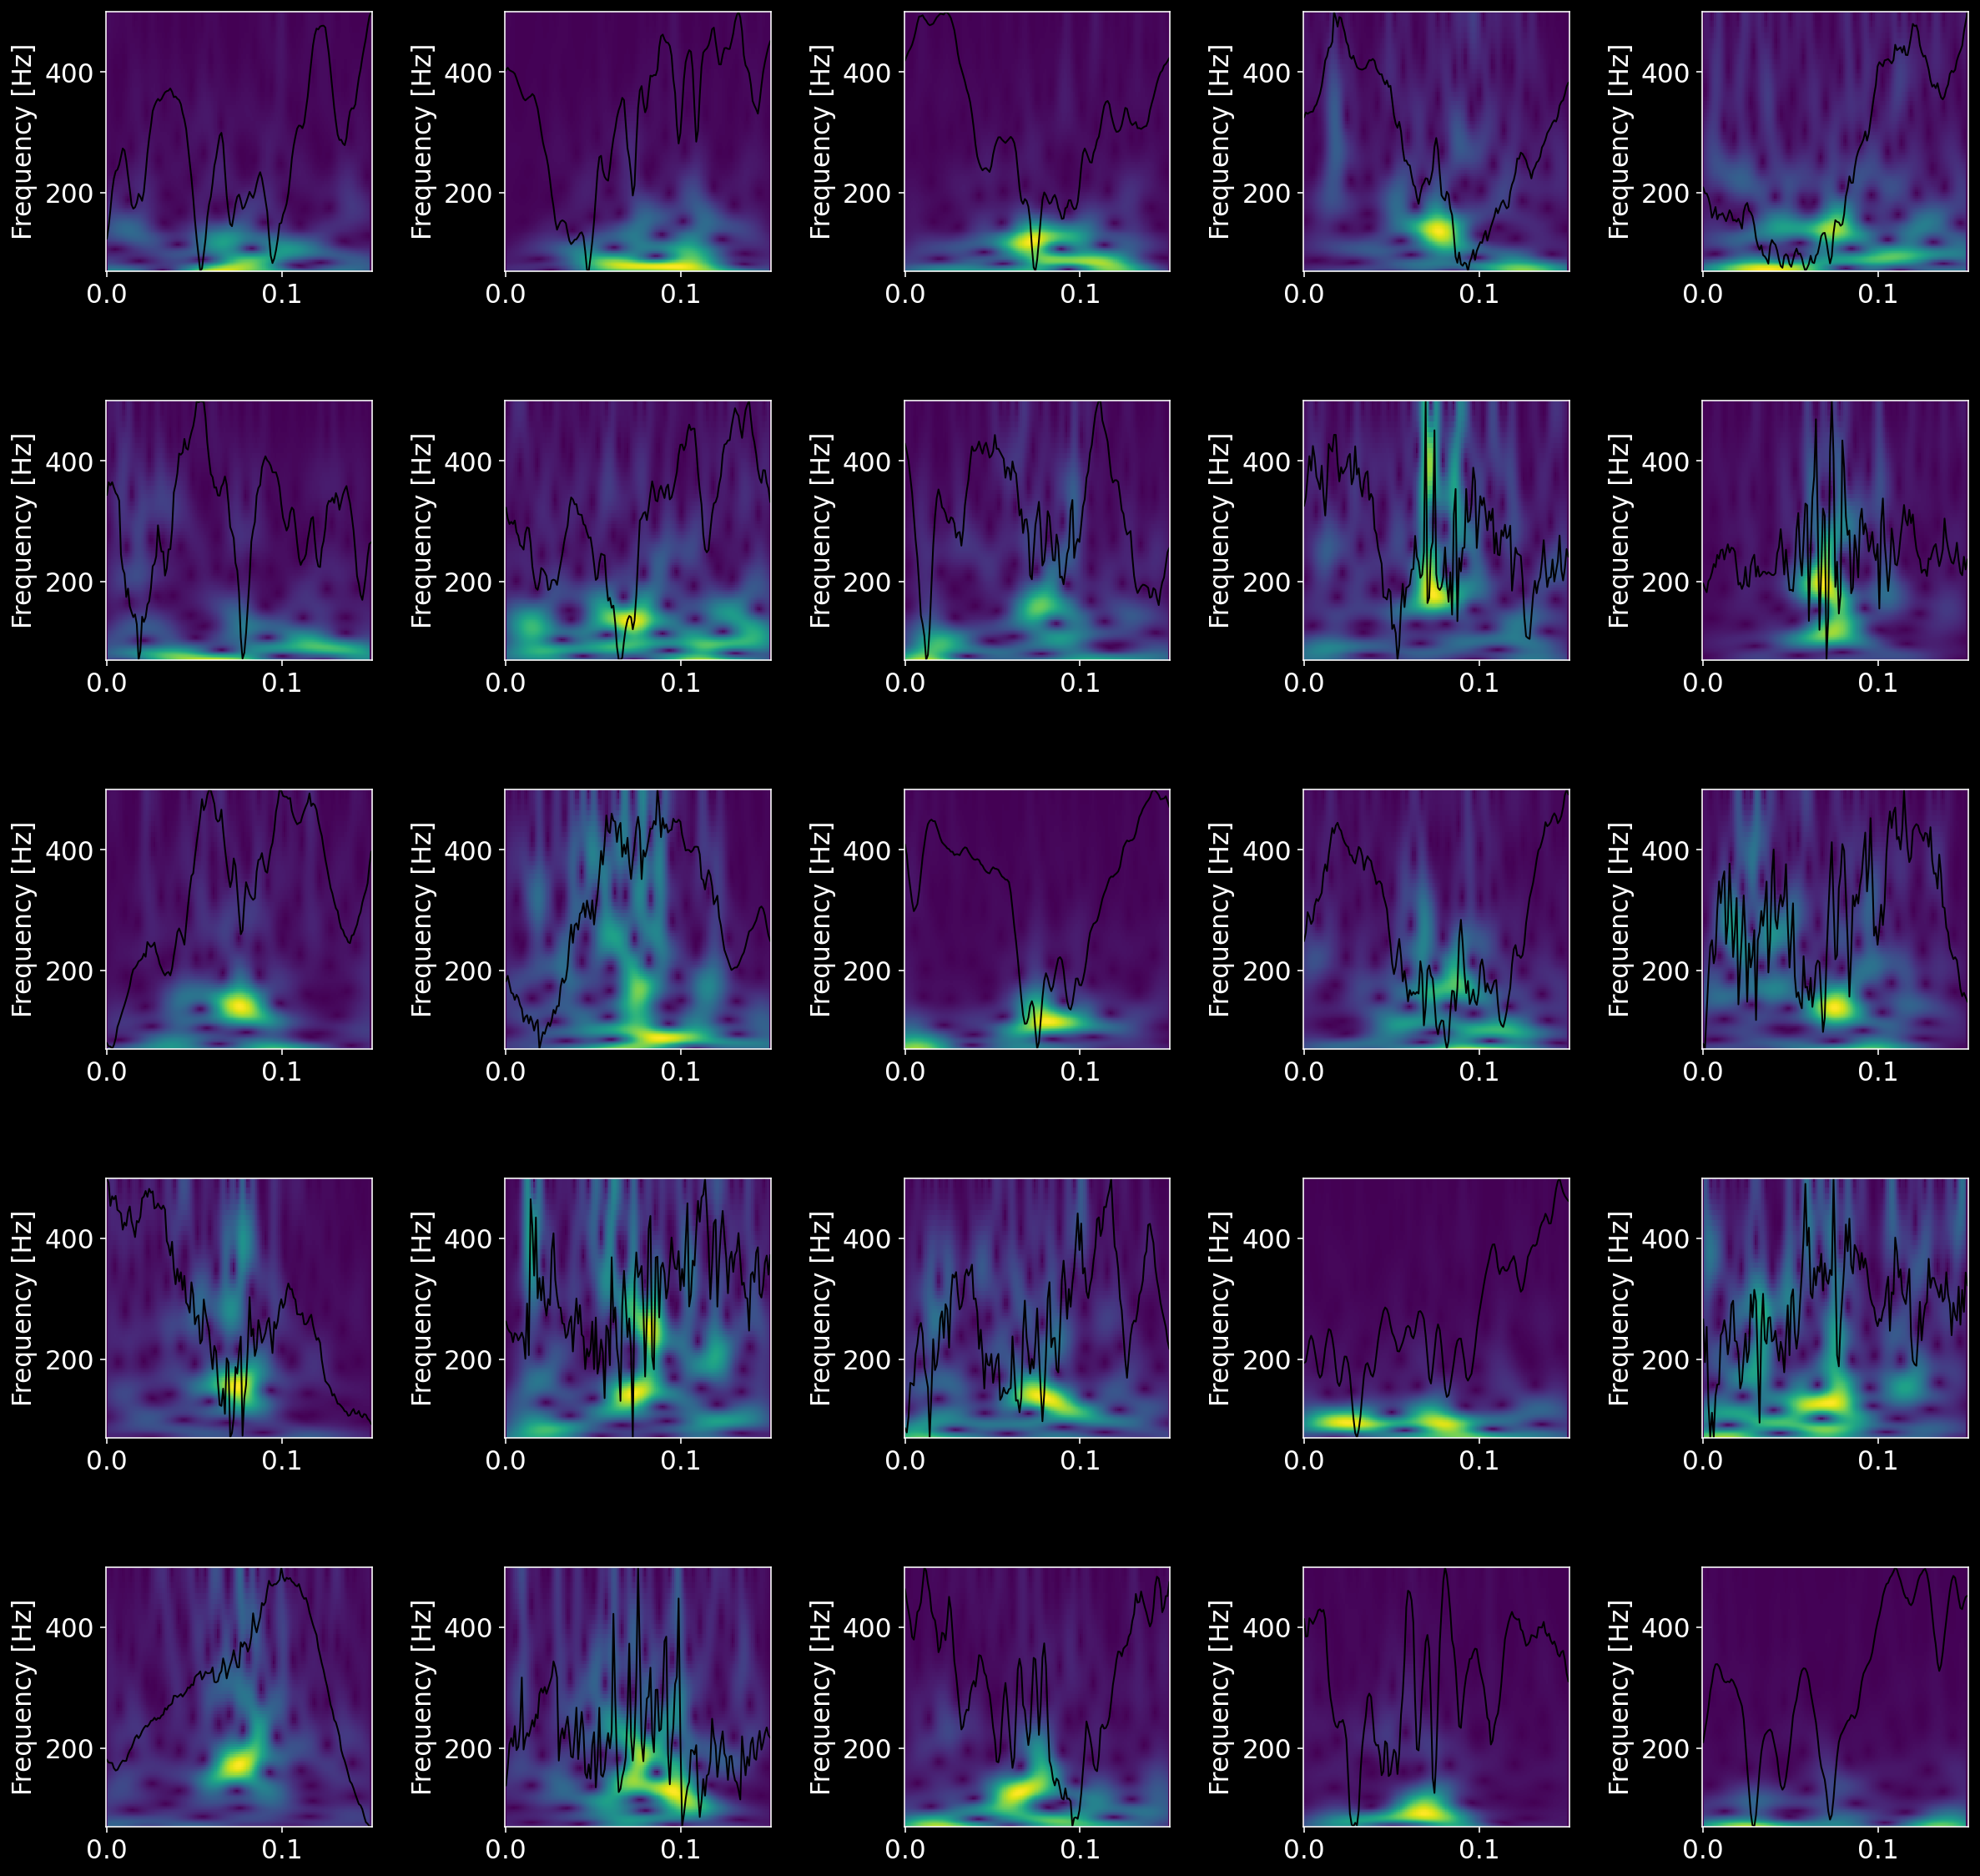

In [346]:

r = np.random.randint(0,len(ripple_maps),25)

fig, axs = plt.subplots(5,5, figsize=(20, 20), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i in range(25):
    get_scalogram(ripple_maps[r[i],:],1000,f_min=70,f_max=500,ax=axs[i])


In [342]:
df

level_0  index  start_time   end_time  ripple_duration  peak_channel  \
0           92    647     26.5048    26.6376           0.1328           0.0   
1          104    659    209.5568   209.6456           0.0888           7.0   
2          145    700    696.5176   696.5760           0.0584           7.0   
3          149    704    716.3400   716.3912           0.0512           7.0   
4          158    713   1174.5808  1174.6600           0.0792           4.0   
...        ...    ...         ...        ...              ...           ...   
31408    38598  57494    320.8456   320.9240           0.0784           4.0   
31409    38599  57495    323.7144   323.7824           0.0680           7.0   
31410    38601  57497     27.7824    27.8336           0.0512           7.0   
31411    38602  57498     70.7024    70.7680           0.0656           6.0   
31412    38609  57505    288.6784   288.7176           0.0392           7.0   

       peak_amplitude   peak_freq                  session classification  \
0          427.088479  236.060848  LEM3116_S20180716174306              1   
1          518.634784  221.545526  LEM3116_S20180716174306              1   
2          408.850930  167.774109  LEM3116_S20180716174306              1   
3          443.597782  180.213903  LEM3116_S20180716174306              0   
4          398.302836  159.521761  LEM3116_S20180716174306              1   
...               ...         ...                      ...            ...   
31408      216.191112  191.971213     RH16_S20161126145021              0   
31409      131.898327  188.687076     RH16_S20161126145021              0   
31410      191.812084  164.097710     RH16_S20161126150318              0   
31411      344.409875  142.250577     RH16_S20161126150318              0   
31412      343.292550  185.057461     RH16_S20161126150318              0   

      classified   range  max_diff   clipped  
0              1  2537.0     941.0  0.000000  
1              1  5567.0    1335.0  0.000000  
2              1  3156.0    1435.0  0.000000  
3              1  3093.0    1485.0  0.013333  
4              1  1660.0     629.0  0.006667  
...          ...     ...       ...       ...  
31408          0  2242.0     581.0  0.000000  
31409          0  2871.0     311.0  0.006667  
31410          0  2461.0     213.0  0.006667  
31411          0  6487.0    1039.0  0.000000  
31412          0  3559.0    2192.0  0.000000  

[31413 rows x 14 columns]

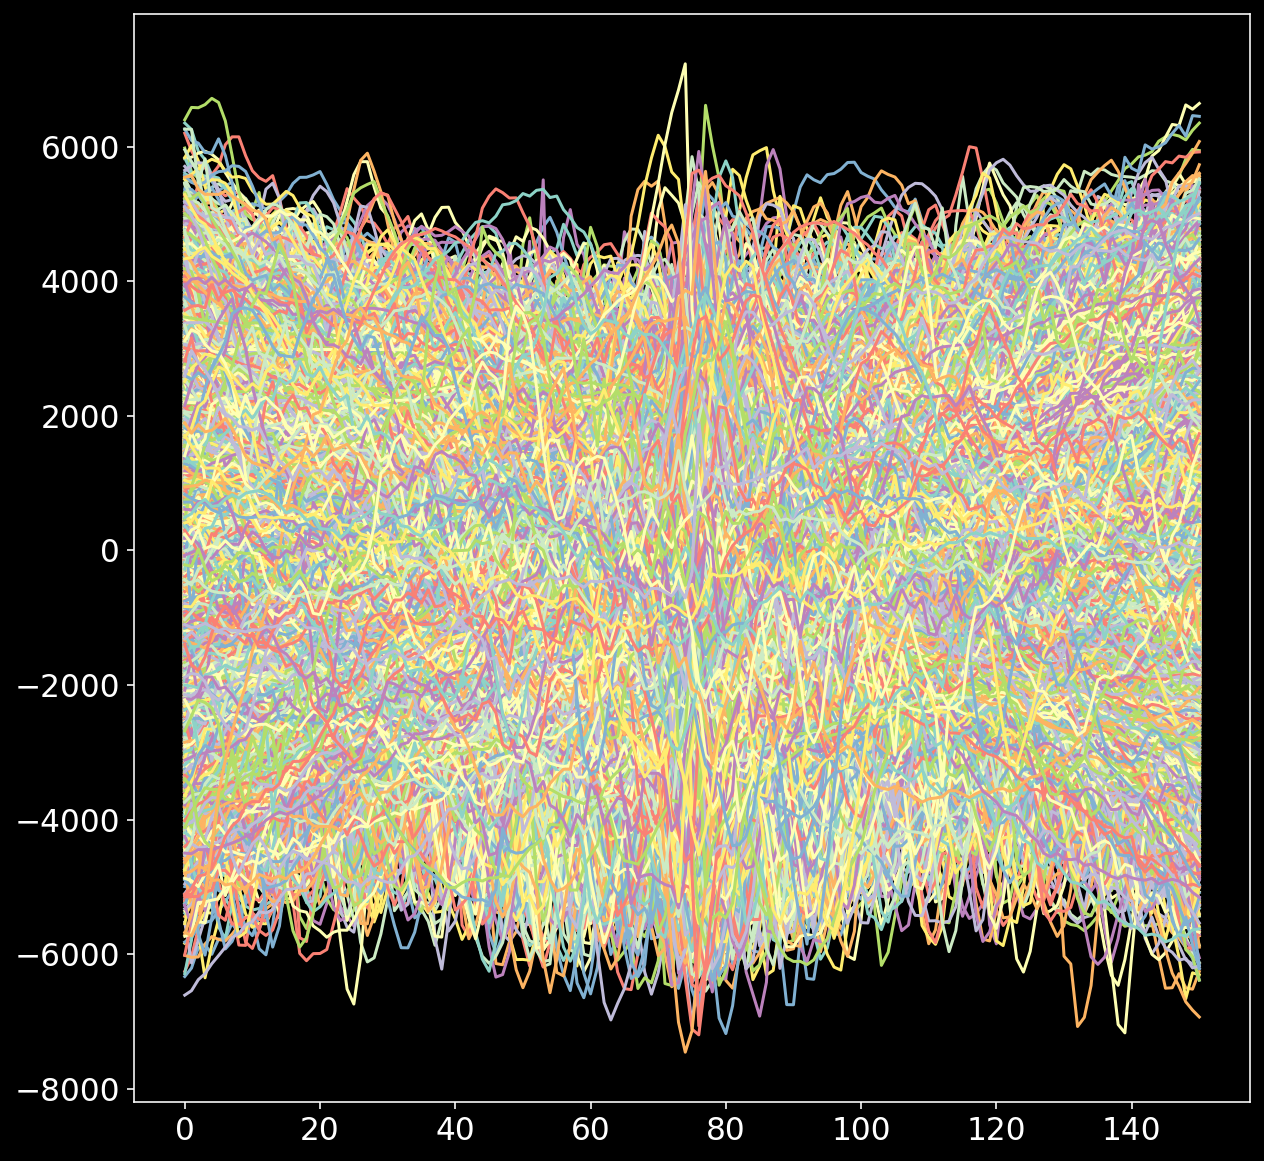

In [345]:
plt.figure(figsize=(10,10))
plt.plot(ripple_maps.T - np.mean(ripple_maps,axis=1))
plt.show()

## attempt at gaussian mixture model on frequency

there are two obvious distrubutions

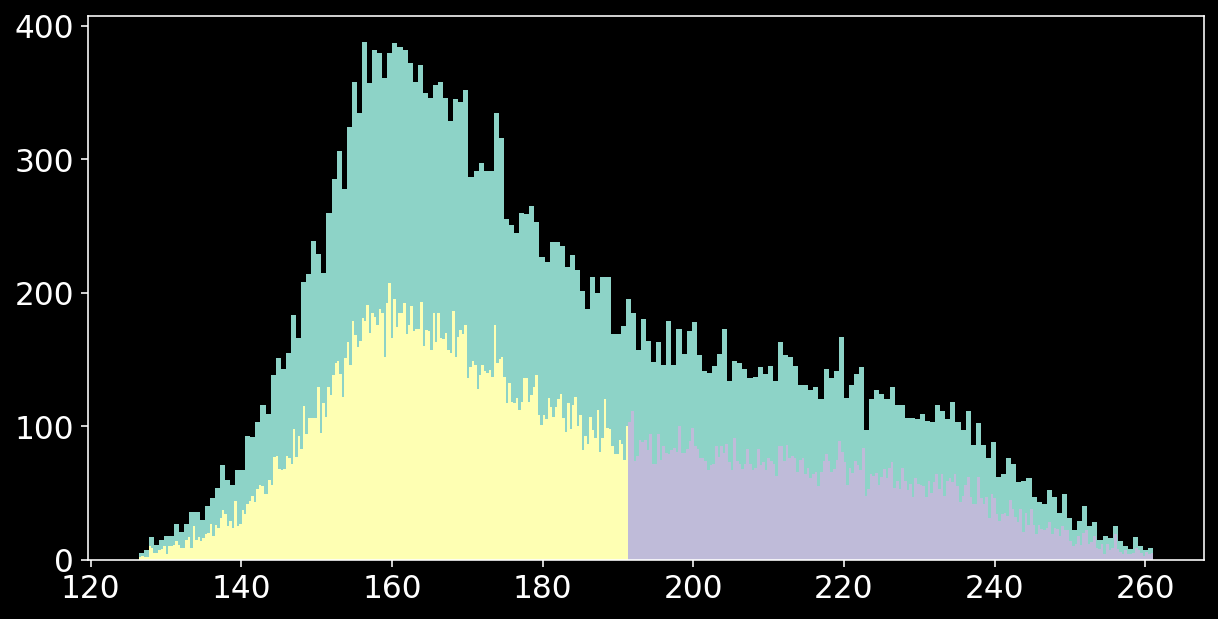

In [334]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2,n_init=10).fit(np.array(df.peak_freq).reshape(-1, 1))
labels = gmm.predict(np.array(df.peak_freq).reshape(-1, 1))

plt.figure(figsize=(10,5))
plt.hist(df.peak_freq,200)
plt.hist(df.peak_freq[labels==0],200)
plt.hist(df.peak_freq[labels==1],200)

plt.show()

# plt.plot(bins, pdf(bins, mu2, sigma2), color='grey')
# plt.scatter(np.ones_like(df.peak_freq), df.peak_freq, c=labels, s=40, cmap='viridis')

In [ ]:
X = [df.ripple_duration,df.peak_amplitude,df.peak_freq]
# X = np.hstack(df.ripple_duration,df.peak_amplitude,df.peak_freq)
# X.shape

In [ ]:
plt.hist(df.ripple_duration,300)
plt.show()

## Detrend testing

In [ ]:
start = 500
stop = 900
channel = 0
plt.figure(figsize=(20,8))

plt.plot(filtered_lfps[start:stop,channel],label='filtered')

norm_range = [np.min(filtered_lfps[start:stop,channel]),np.max(filtered_lfps[start:stop,channel])]
plt.plot(normalize(lfp[start:stop,channel],norm_range),label='raw')

plt.plot(detrend(normalize(lfp[start:stop,channel],norm_range),type='linear'),label='detrend')

plt.legend()

## label ripples as true positive & false positive

In [ ]:
from IPython.display import clear_output
clear_output(wait=True)
value = []
i = 0
for ripple in ripple_maps:
    plt.plot(ripple)
    plt.show()
    print(i, 'of',len(ripple_maps))
    value.append(input("ripple ?: "))
    clear_output()
    i+=1

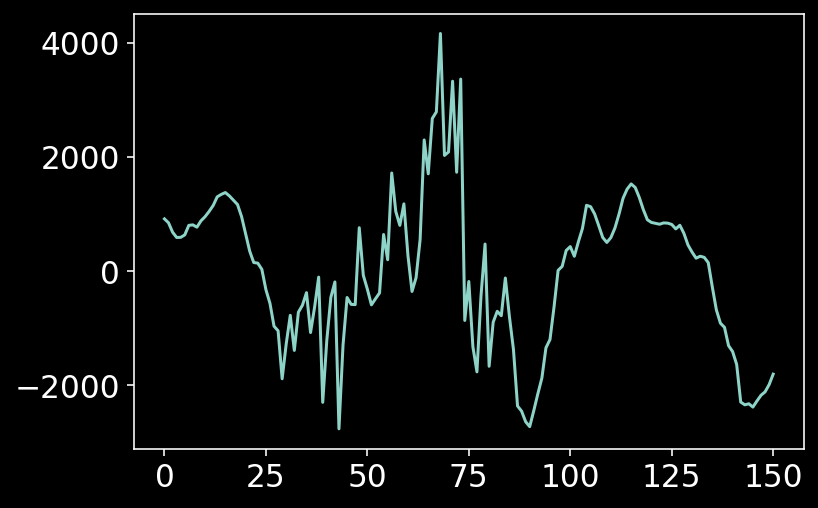

7831 of 57579
ripple ?: 2
saving...
F:\Projects\PAE_PlaceCell\swr_data\classified/swr_df_08_29_21.pkl


In [31]:
from IPython.display import clear_output
clear_output(wait=True)

def save_exit(df,save_path,classification,classified):
    df["classification"] = classification
    df["classified"] = classified 
    print('saving...')
    save_df_path = save_path +'classified'+'/swr_df_' + time.strftime("%H_%M_%S", time.localtime()) + '.pkl'
    print(save_df_path)
    df.to_pickle(save_df_path)
    return df
    
def check_for_saved_file(save_path):
    files = glob.glob(save_path +'classified'+'/*.pkl')
    latest_file = max(files, key=os.path.getctime)
    print('reading... '+latest_file)
    df = pd.read_pickle(latest_file)
    return df

def classify_ripples(df,ripple_maps,save_path):
    auto_save_i = 0
    
    df = check_for_saved_file(save_path)
    
    if 'classified' in df:
        print('found saved work')
        classification = df.classification
        classified = df.classified 
        last_idx = sum(classified)
    else:
        classification = np.zeros_like(df.session)
        classified = np.zeros_like(df.session)
        last_idx = 0
        
    for i in np.arange(last_idx,len(df),1):

        plt.plot(ripple_maps[i] - np.mean(ripple_maps[i]))
        plt.show()

        print(i, 'of',len(ripple_maps))

        val = input("ripple ?: ")
        if not val:
            val = input("opps... empty entry. Try again. ripple ?: ")
            
        if int(val) > 1:
            df = save_exit(df,save_path,classification,classified)
            return df
        
        classification[i] = int(val)
        classified[i] = 1

        clear_output()
        
        if auto_save_i > 100:
            print('auto_saving...')
            df = save_exit(df,save_path,classification,classified)
            auto_save_i = 0
            
        auto_save_i += 1
        
    if i == len(df):
        df = save_exit(df,save_path,classification,classified)
        return df

    
    
df = classify_ripples(df,ripple_maps,save_path)

In [32]:
df

start_time  end_time  ripple_duration  peak_channel  peak_amplitude  \
0         67.5472   67.6368           0.0896           3.0      722.301792   
1        104.2456  104.3496           0.1040           4.0      672.901662   
2        215.2024  215.3496           0.1472           1.0     5958.794132   
3        302.9792  303.0992           0.1200           4.0     2803.005328   
4        309.5952  309.6744           0.0792           1.0      555.847002   
...           ...       ...              ...           ...             ...   
57574    526.3392  526.4648           0.1256           3.0      247.555298   
57575    539.3456  539.4048           0.0592           0.0      158.007427   
57576    543.7880  543.8256           0.0376           3.0      153.679329   
57577    545.8168  545.8912           0.0744           0.0      172.187552   
57578    555.6400  555.7792           0.1392           3.0     5976.093926   

        peak_freq                 session classification classified    range  
0      180.012548  LE2813_S20170920115122              0          1   5536.0  
1      238.574525  LE2813_S20170920115122              1          1   2368.0  
2      142.732740  LE2813_S20170920115122              0          1  35581.0  
3      180.547277  LE2813_S20170920115122              0          1  21648.0  
4      183.428506  LE2813_S20170920115122              0          1   5438.0  
...           ...                     ...            ...        ...      ...  
57574  243.367807    RH16_S20161207130642              0          0   3310.0  
57575  167.179523    RH16_S20161207130642              0          0    936.0  
57576  197.917565    RH16_S20161207130642              0          0   4541.0  
57577  173.225576    RH16_S20161207130642              0          0  30009.0  
57578  187.063424    RH16_S20161207130642              0          0      0.0  

[57579 rows x 10 columns]

In [35]:
print('true / positive ' + str(sum(df.classification) / sum(df.classified)))
print('false / positive ' + str(1 - (sum(df.classification) / sum(df.classified))))
print('% labeled ' + str((sum(df.classified)/len(df)) * 100))

true / positive 0.7712935768101137
false / positive 0.22870642318988632
% labeled 13.600444606540579


In [33]:
print('labeled sessions')
print(pd.unique(df.session[df.classification==1]))

labeled sessions
['LE2813_S20170920115122' 'LE2821_S20171012114532' 'LE2821_S20171023141225'
 'LE2821_S20171026105920' 'LE2823_S20171204142319'
 'LEM3116_S20180713111238' 'LEM3116_S20180715121821'
 'LEM3116_S20180715160836' 'LEM3116_S20180716115155'
 'LEM3116_S20180716174306' 'LEM3116_S20180717110938'
 'LEM3116_S20180717203042' 'LEM3116_S20180718160658'
 'LEM3116_S20180718184628' 'LEM3116_S20180719120803'
 'LEM3116_S20180719173052' 'LEM3116_S20180720112057'
 'LEM3116_S20180727123953' 'LEM3116_S20180728123155'
 'LEM3116_S20180728165712' 'LEM3116_S20180731114926'
 'LEM3116_S20180802100324' 'LEM3116_S20180803103321'
 'LEM3116_S20180806104145' 'LEM3116_S20180807105247'
 'LEM3116_S20180808160117' 'LEM3116_S20180809122404'
 'LEM3116_S20180810110603' 'LEM3116_S20180812141038'
 'LEM3116_S20180813102918' 'LEM3116_S20180814141527'
 'LEM3116_S20180815132530' 'LEM3116_S20180817153256'
 'LEM3116_S20180819114815' 'LEM3116_S20180820160259'
 'LEM3120_S20180923183326' 'LEM3120_S20180924174015'
 'LEM312

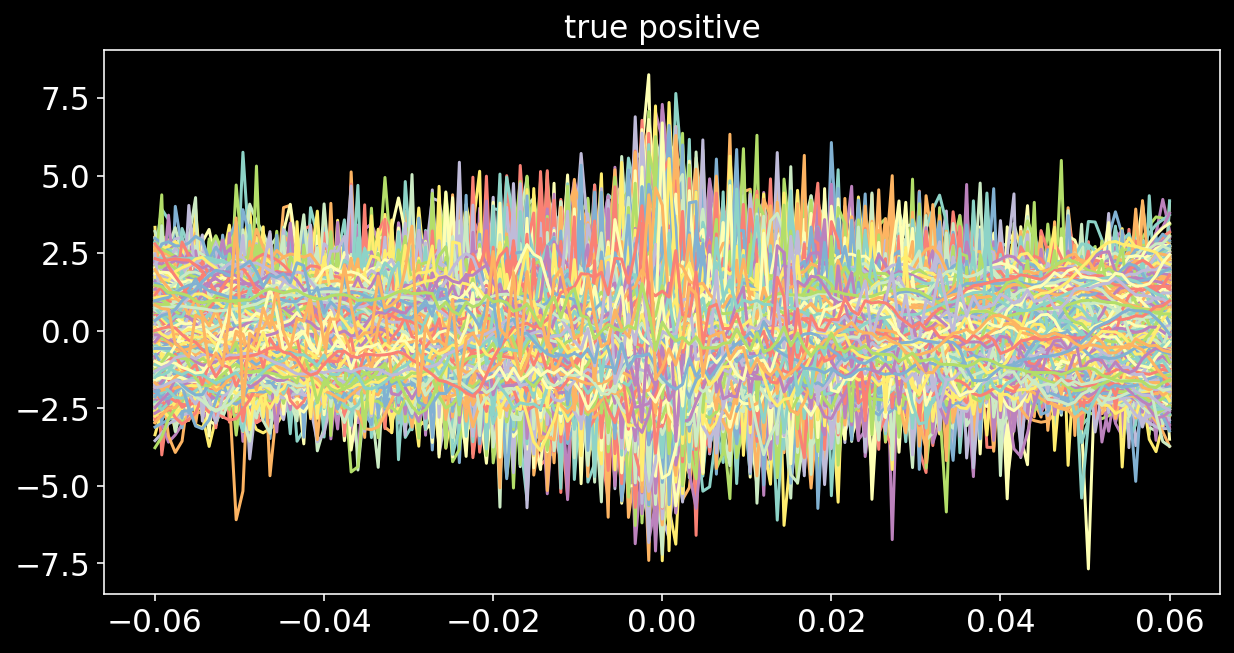

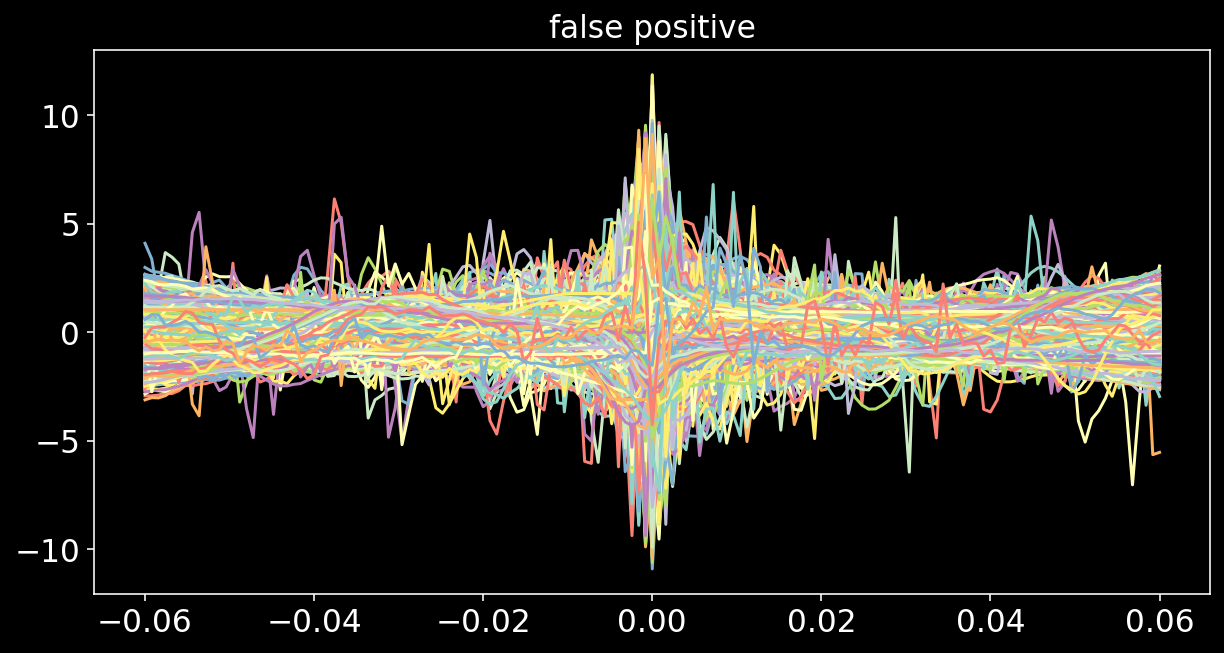

In [268]:
plt.figure(figsize=(10,5))

idx = np.logical_and(df.classified==1, df.classification==1)
plt.plot(np.arange(-75,76,1)/1250,stats.zscore(ripple_maps[idx],axis=1).T)
# plt.plot(np.arange(-75,76,1)/1250,ripple_maps[idx].T)

plt.title('true positive')
plt.show()

plt.figure(figsize=(10,5))
idx = np.logical_and(df.classified==1, df.classification==0)
plt.plot(np.arange(-75,76,1)/1250,stats.zscore(ripple_maps[idx],axis=1).T)
plt.title('false positive')
plt.show()

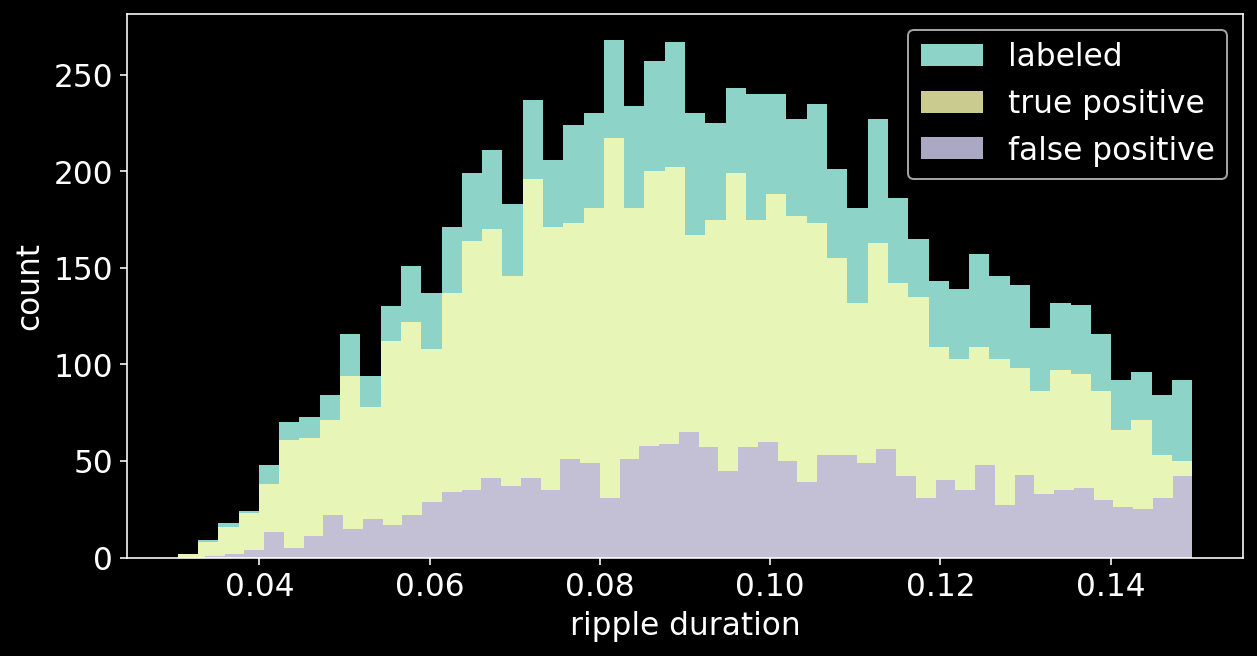

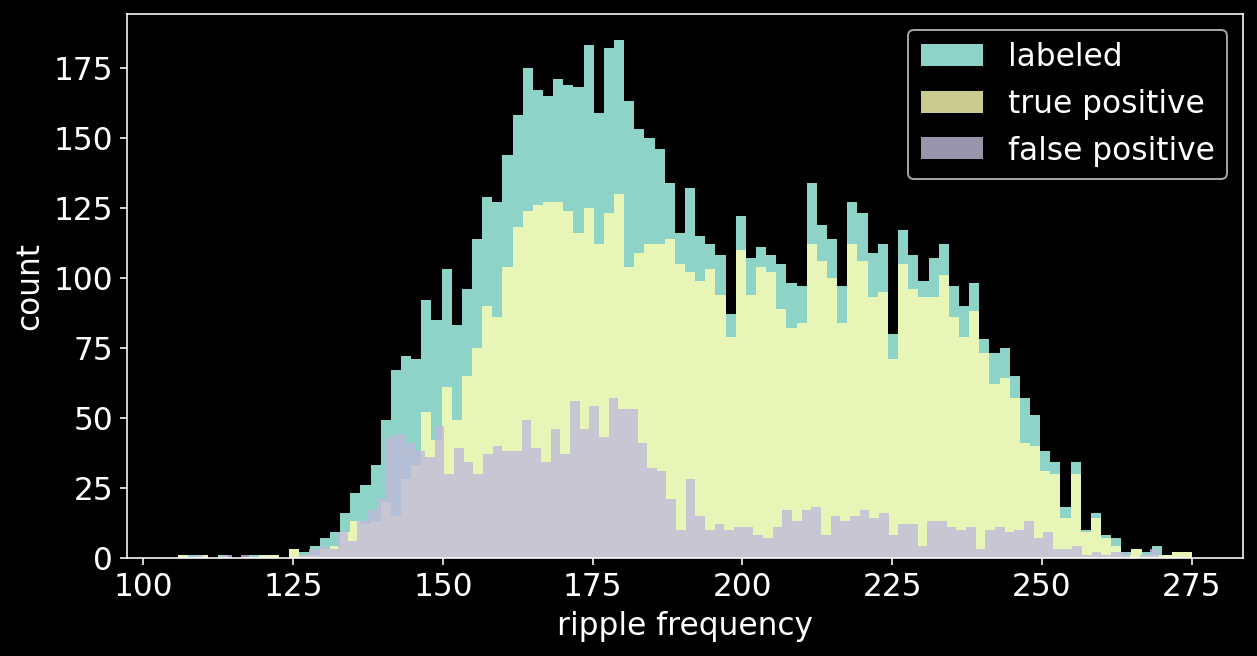

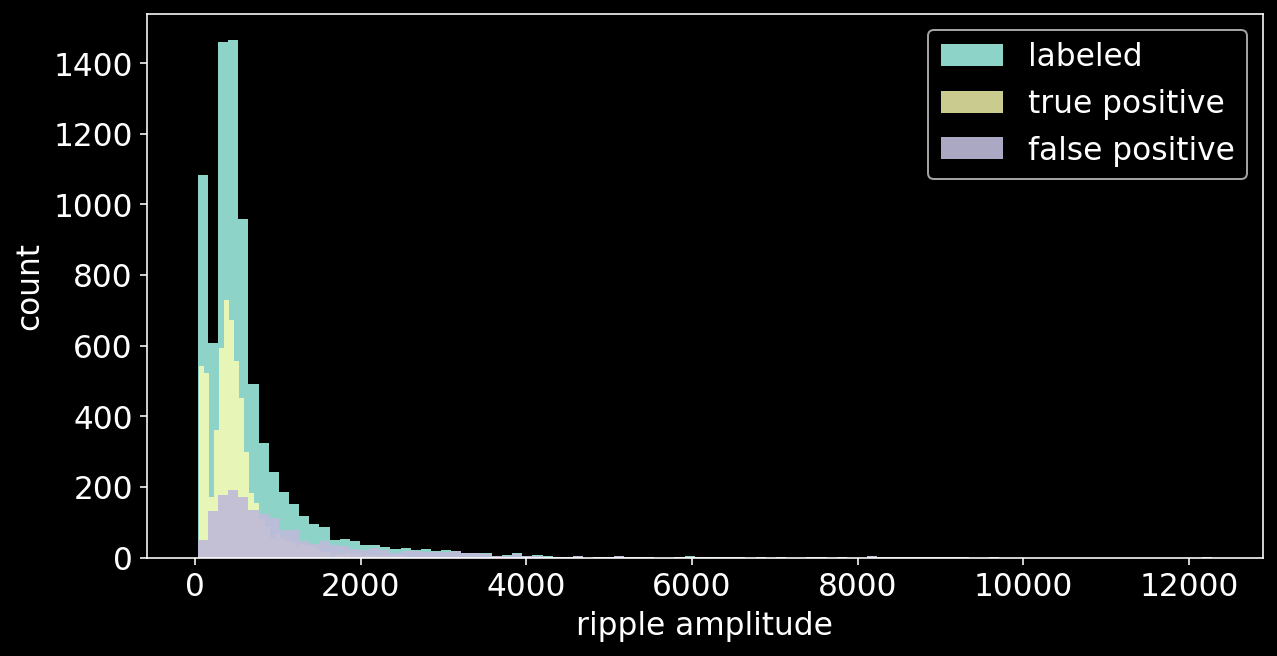

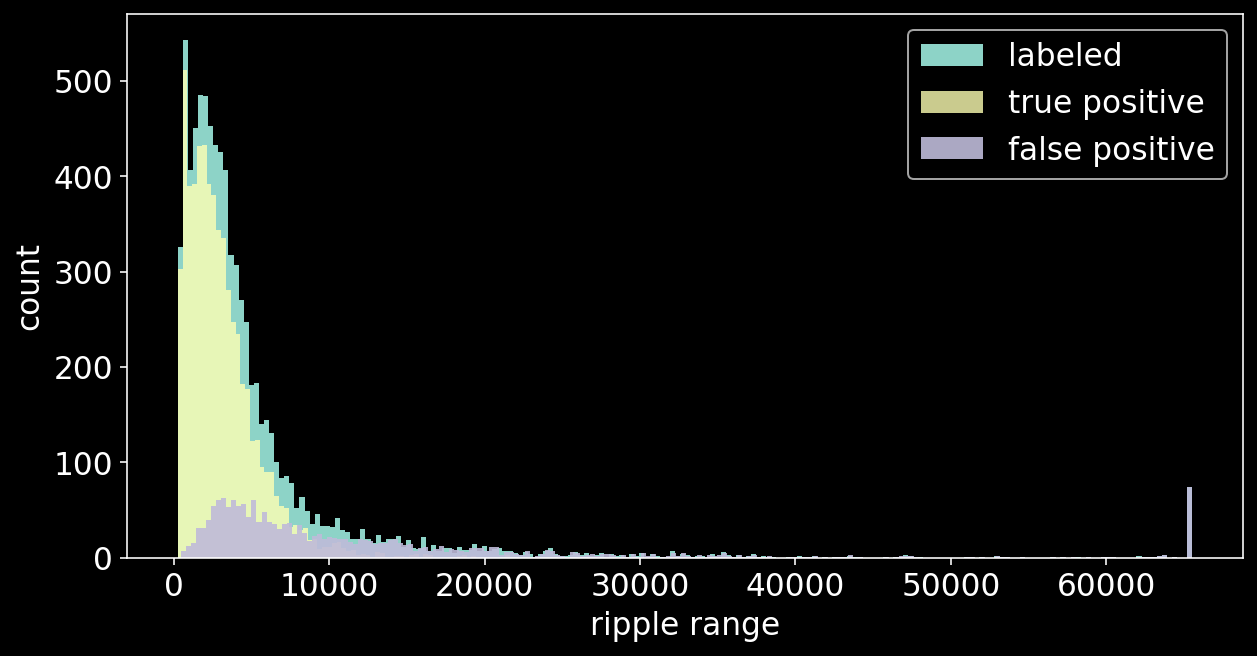

In [34]:
plt.figure(figsize=(10,5))
idx = (df.classified==1)
plt.hist(df.ripple_duration[idx],50,label='labeled')

idx = np.logical_and(df.classified==1, df.classification==1)
plt.hist(df.ripple_duration[idx],50,alpha=0.8,label='true positive')

idx = np.logical_and(df.classified==1, df.classification==0)
plt.hist(df.ripple_duration[idx],50,alpha=0.9,label='false positive')

plt.xlabel('ripple duration')
plt.ylabel('count')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
idx = (df.classified==1)
plt.hist(df.peak_freq[idx],100,label='labeled')

idx = np.logical_and(df.classified==1, df.classification==1)
plt.hist(df.peak_freq[idx],100,alpha=0.8,label='true positive')

idx = np.logical_and(df.classified==1, df.classification==0)
plt.hist(df.peak_freq[idx],100,alpha=0.8,label='false positive')

plt.xlabel('ripple frequency')
plt.ylabel('count')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
idx = (df.classified==1)
plt.hist(df.peak_amplitude[idx],100,label='labeled')

idx = np.logical_and(df.classified==1, df.classification==1)
plt.hist(df.peak_amplitude[idx],100,alpha=0.8,label='true positive')

idx = np.logical_and(df.classified==1, df.classification==0)
plt.hist(df.peak_amplitude[idx],100,alpha=0.9,label='false positive')

plt.xlabel('ripple amplitude')
plt.ylabel('count')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
idx = (df.classified==1)
plt.hist(df.range[idx],200,label='labeled')

idx = np.logical_and(df.classified==1, df.classification==1)
plt.hist(df.range[idx],200,alpha=0.8,label='true positive')

idx = np.logical_and(df.classified==1, df.classification==0)
plt.hist(df.range[idx],200,alpha=0.9,label='false positive')

plt.xlabel('ripple range')
plt.ylabel('count')
plt.legend()
plt.show()



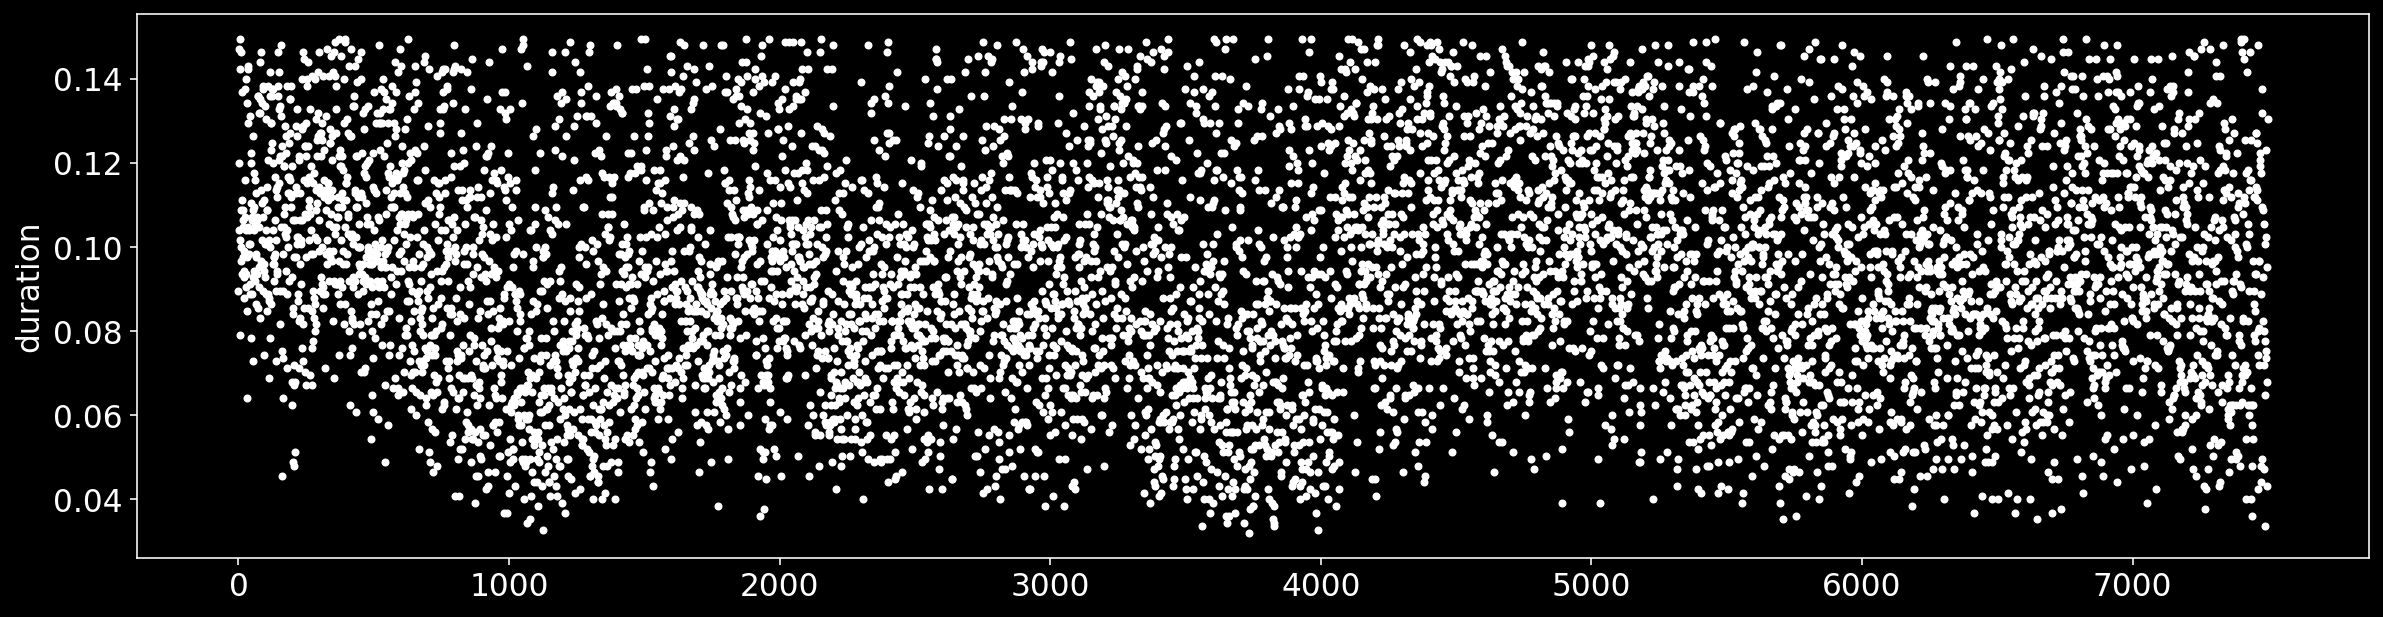

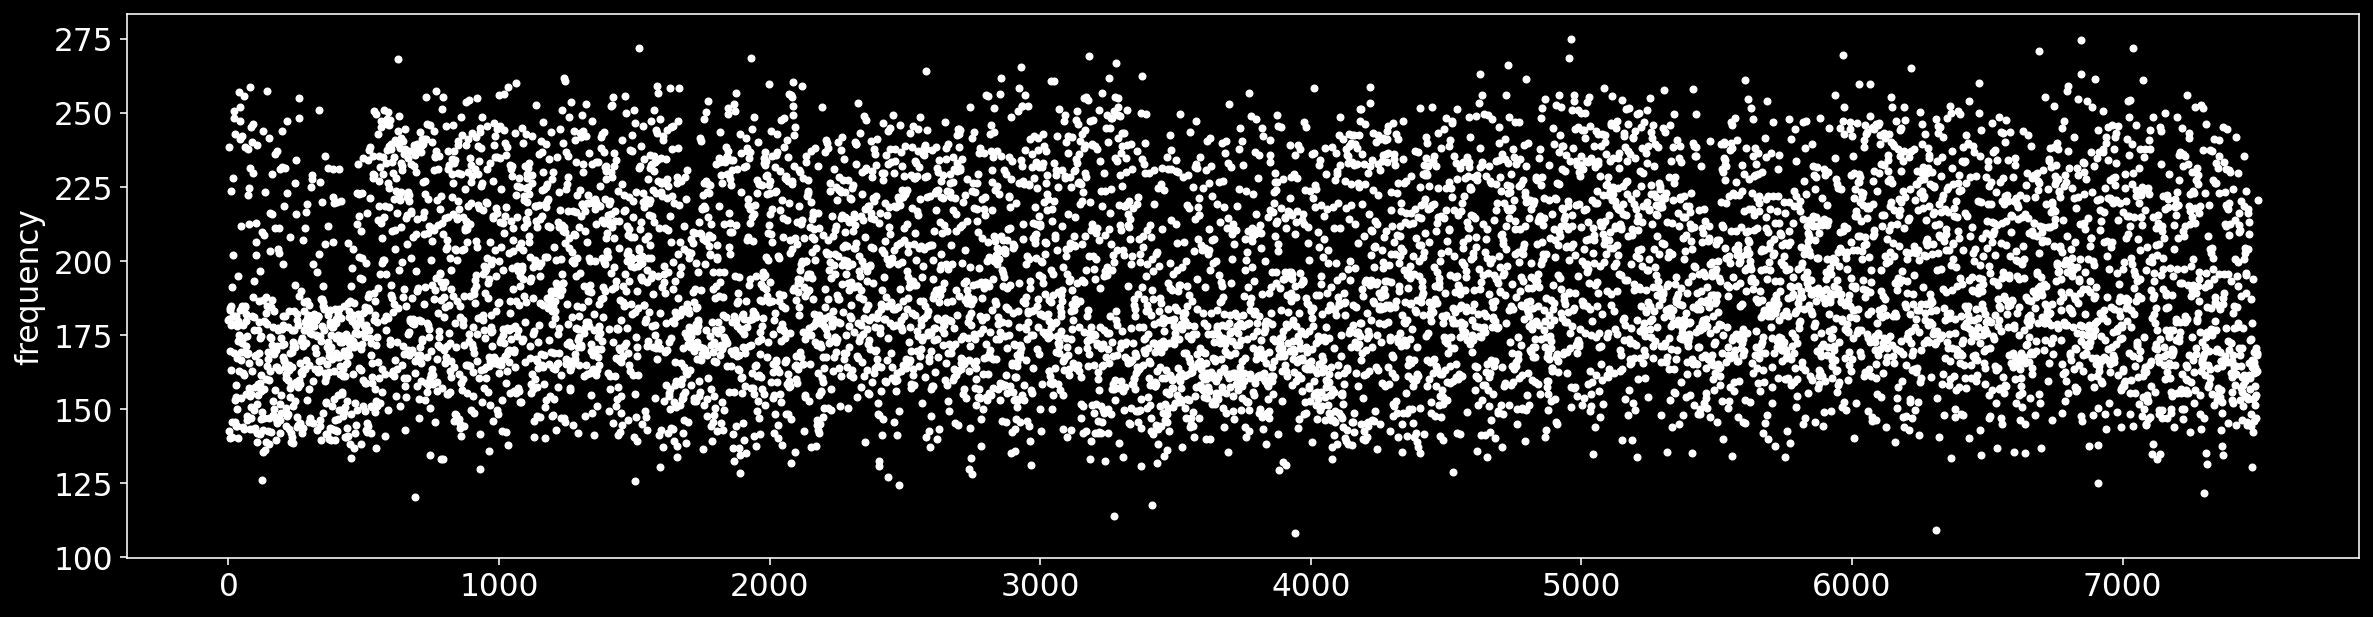

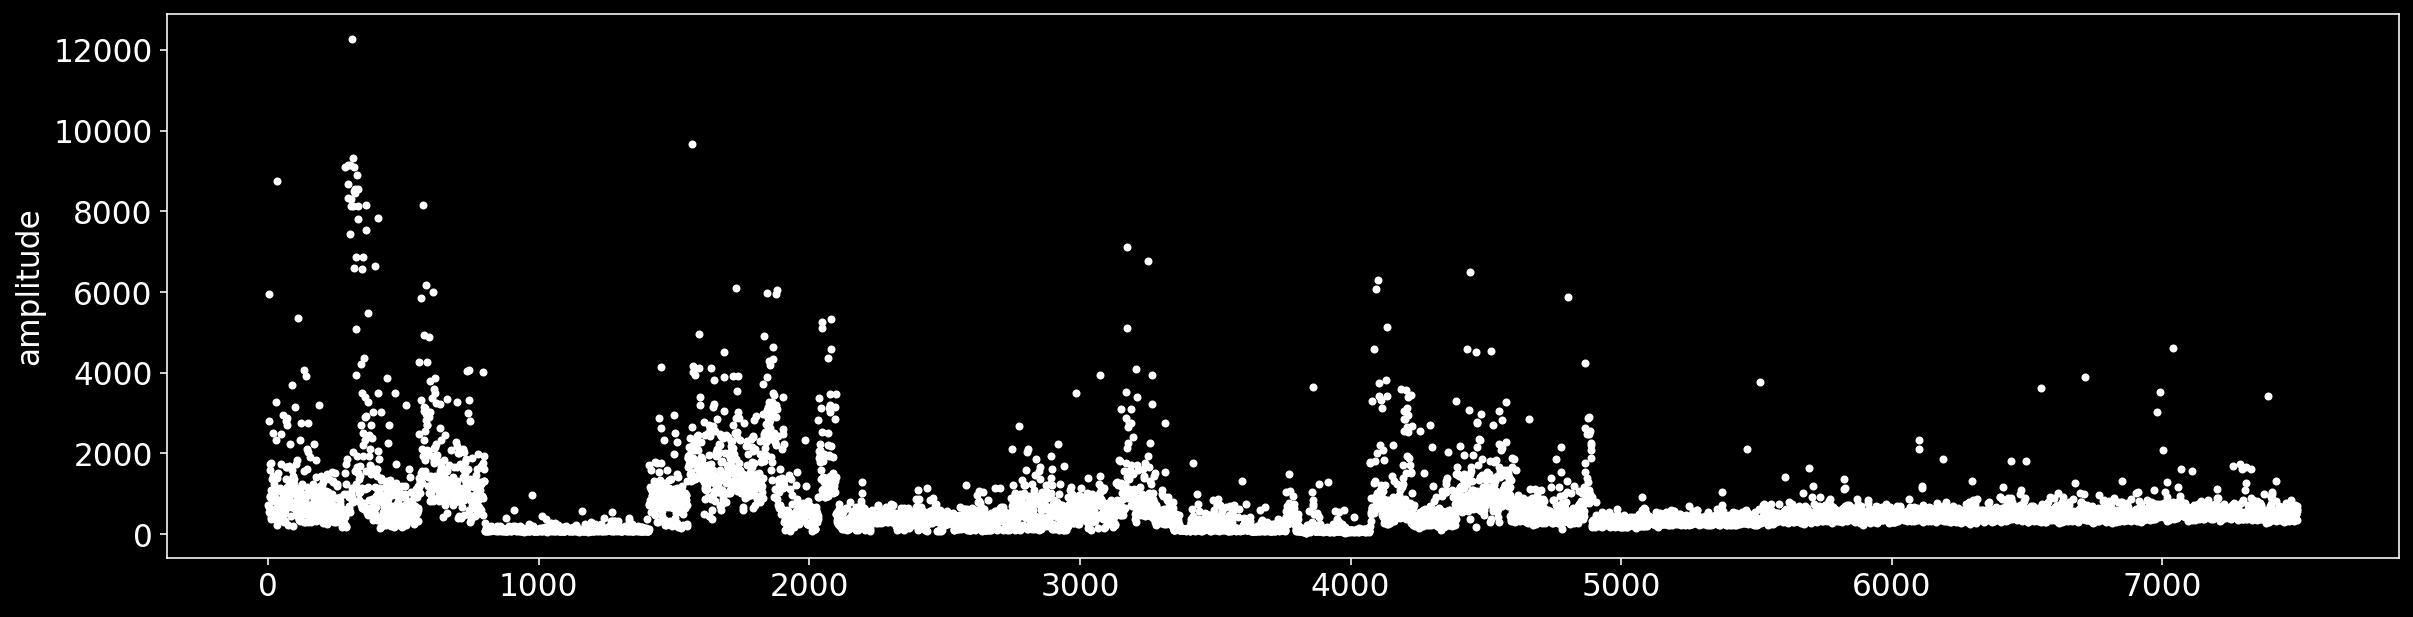

In [261]:
plt.figure(figsize=(20,5))
idx = (df.classified==1)
plt.plot(df.ripple_duration[idx],'.w')
plt.ylabel('duration')
plt.show()


plt.figure(figsize=(20,5))
idx = (df.classified==1)
plt.plot(df.peak_freq[idx],'.w')
plt.ylabel('frequency')
plt.show()


plt.figure(figsize=(20,5))
idx = (df.classified==1)
plt.plot(df.peak_amplitude[idx],'.w')
plt.ylabel('amplitude')
plt.show()

In [ ]:
# with open('F:\Projects\PAE_PlaceCell\swr_data\labels\labeled_data_updated.pkl', 'wb') as f:
#     pickle.dump(value, f)
    
# with open(r'F:\Projects\PAE_PlaceCell\swr_data\labels\ripple_maps.pkl', 'wb') as f:
#     pickle.dump(ripple_maps, f)  

In [ ]:
# with open(r'F:\Projects\PAE_PlaceCell\swr_data_older\labels\labeled_data_updated.pkl', 'rb') as f:
#         value = pickle.load(f)


In [85]:
import neuroseries as nts

def make_Epochs(start, end):
    #Function to make an nts.IntervalSet dataframe with starting and ending epochs
    #Firstly, check whether both the lists are of same size or not
    if not (len(start) == len(end)):
        print("Start and End array lists are not of same dimension. Epochs IntervalSet can't be developed.")
        sys.exit()
    else:
        nts_array = []
        for i in range(len(start)):
            nts_array.append(nts.IntervalSet(start[i], end[i]))
        print(nts_array)
        return nts_array
    
def writeNeuroscopeEvents(path, ep, name):
    f = open(path, 'w')
    for i in range(len(ep)):
        f.writelines(str(ep.as_units('ms').iloc[i]['start']) + " "+name+" start "+ str(1)+"\n")
        #f.writelines(str(ep.as_units('ms').iloc[i]['peak']) + " "+name+" start "+ str(1)+"\n")
        f.writelines(str(ep.as_units('ms').iloc[i]['end']) + " "+name+" end "+ str(1)+"\n")
    f.close()
    return

In [96]:
idx = df.session == 'LEM3216_S20190710184004'

start_time = nts.TsdFrame(df.start_time[idx], time_units = 's')
end_time = nts.TsdFrame(df.end_time[idx], time_units = 's')

rpt_ep = nts.IntervalSet(np.array(df.start_time[idx]), np.array(df.end_time[idx]),time_units = 's')

new_path = 'F:/Projects/PAE_PlaceCell/data/LEM3216/2019-07-10_18-40-04/'
writeNeuroscopeEvents(new_path + "Swr_Ripple.evt.rip", rpt_ep, "SWR Ripple event")



          start         end
0        176800      248800
1        491200      611200
2        616000      704000
3      10210400    10260800
4      16776800    16853600
..          ...         ...
336  2761537600  2761599200
337  2781727200  2781832800
338  2784445600  2784521600
339  2791662400  2791760000
340  2793452000  2793500000

[341 rows x 2 columns]


In [94]:
new_path + "Swr_Ripple.evt.rip"

'F:\\Projects\\PAE_PlaceCell\\data\\LE2813\\2017-09-20_11-51-22Swr_Ripple.evt.rip'

In [78]:
nts.IntervalSet(1,6)

start  end
0      1    6

## plot all labeled ripples

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 40), edgecolor='k')

add_ = np.linspace(0,200,sum(np.array(value) == '1'))
axs[0].plot(stats.zscore(ripple_maps_labeled,axis=1)[np.array(value) == '1'].T + add_)

add_ = np.linspace(0,200,sum(np.array(value) == '0'))
axs[1].plot(stats.zscore(ripple_maps_labeled,axis=1)[np.array(value) == '0'].T + add_)
plt.show()


fig, axs = plt.subplots(1,2, figsize=(10, 5), edgecolor='k')

# axs[0].plot(stats.zscore(ripple_maps_labeled,axis=1)[np.array(value) == '1'].T)
axs[0].plot(np.mean(stats.zscore(ripple_maps_labeled,axis=1)[np.array(value) == '1'].T,axis=1))

axs[1].plot(np.mean(stats.zscore(ripple_maps_labeled,axis=1)[np.array(value) == '0'].T,axis=1))
plt.show()


## plot wavelets behind ripples

In [ ]:
maps = ripple_maps_labeled[np.array(value) == '1',:]

r = np.random.randint(0,len(maps),25)

fig, axs = plt.subplots(5,5, figsize=(20, 20), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i in range(25):
    get_scalogram(maps[r[i],:],1000,f_min=70,f_max=500,ax=axs[i])


In [ ]:
# false positives
maps = ripple_maps_labeled[np.array(value) == '0',:]

r = np.random.randint(0,len(maps),25)

fig, axs = plt.subplots(5,5, figsize=(20, 20), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()
for i in range(25):
    get_scalogram(maps[r[i],:],1000,f_min=70,f_max=500,ax=axs[i])

In [ ]:
scalogram = []
for map in ripple_maps_labeled:
    scalogram.append(get_scalogram(map,1000,f_min=70,f_max=500,fig=0).flatten())
scalogram = np.vstack(scalogram)     

In [ ]:
scalogram

In [9]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# idx = np.logical_and(df.classified==1, df.classification==1)

# X = stats.zscore(ripple_maps[df.classified == 1,:],axis=1)

X = np.matrix((df.ripple_duration[df.classified == 1],
               df.peak_amplitude[df.classified == 1],
               df.peak_freq[df.classified == 1],
               df.range[df.classified == 1])).T

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

print(X.shape)

# y = np.array(value)
y = np.array(df.classification[df.classified == 1]).astype('int')
print(y.shape)

# X = scalogram
# y = np.array(value)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

print(len(y_train))
print(len(y_test))
print(len(y_val))

(7644, 4)
(7644,)
4586
1529
1529


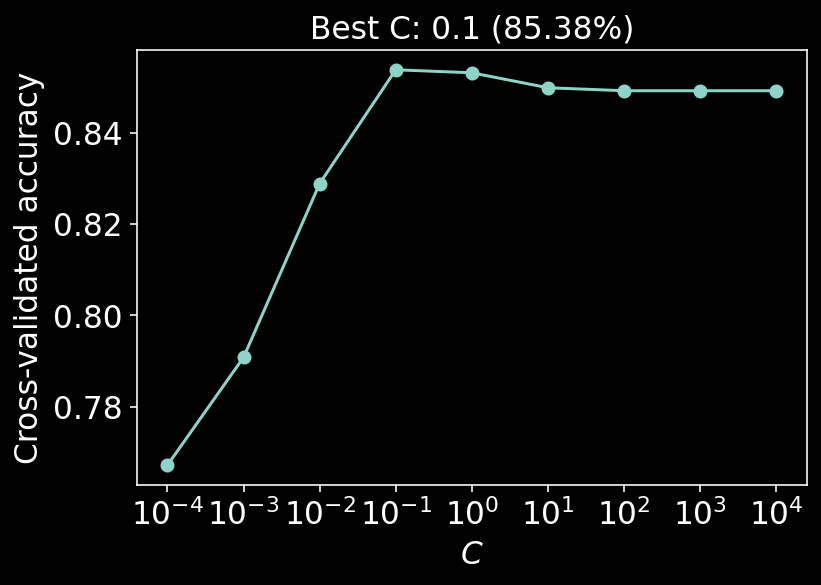

In [339]:
def model_selection(X, y, C_values):
  """Compute CV accuracy for each C value.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): Array of hyperparameter values

  Returns:
    accuracies (1D array): CV accuracy with each value of C

  """
  #############################################################################
  # TODO Complete the function and remove the error
  # raise NotImplementedError("Implement the model_selection function")
  #############################################################################

  accuracies = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l2", C=C, max_iter=5000)

    # Get the accuracy for each test split
    accs = cross_val_score(model, X, y, cv=8)

    # Store the average test accuracy for this value of C
    accuracies.append(accs.mean())

  return accuracies

def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="$C$",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )
    
# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Uncomment and run when the function is ready to test
accuracies = model_selection(X_val, y_val, C_values)
plot_model_selection(C_values, accuracies)

## grid search pipline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, GridSearchCV

model = LogisticRegression(max_iter = 5000)

### Set Testing Parameters
# Create pipeline
pipe_clf = Pipeline([('clf', model)])

C_values = np.logspace(-4, 4, 9)

# Set parameters to test during optimization
param_grid_clf = [
   { 
        "clf__penalty": ["l2"],
        "clf__C":[0.001,0.01,0.1,1],
        "clf__solver":["newton-cg", "lbfgs", "sag","saga"],
        "clf__class_weight":["balanced","none"]
   },
   { 
        "clf__penalty": ["l1"],
        "clf__C":[0.001,0.01,0.1,1],
        "clf__solver":["saga","liblinear"],
        "clf__class_weight":["balanced","none"]
   },  
   { 
        "clf__penalty": ["elasticnet"],
        "clf__C":[0.001,0.01,0.1],
        "clf__solver":["saga"],
        "clf__class_weight":["balanced","none"]
   } 
]


# Define function
def model_selection(X,y,pipe,param_grid):
    
    # See if L1 or L2 regularization leads to better classification accuracy with 5 fold cross validation
    cv = RepeatedKFold(n_splits=2, n_repeats=5, random_state=1)
    grid = GridSearchCV(pipe, cv=cv, param_grid=param_grid)
    grid.fit(X,y)
    
    # Print Summary of the results
    print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    params = grid.cv_results_['params']
    
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
    # save the best model
    model = grid.best_estimator_
    return model

model_ = model_selection(X_val,y_val,pipe_clf,param_grid_clf)

In [10]:


model_ = LogisticRegression(penalty="l2", C=0.1).fit(X_train, y_train)
accs = cross_val_score(model_, X_val, y_val, cv=8)
print(accs)
# model = LogisticRegression(random_state=0).fit(X_train, y_train)
print(model_.classes_)
print(model_.predict_proba(X_test))
print(model_.predict(X_test))
# print(model.score(X_test, y_test))

model_.score(X_test, y_test)

# accs = cross_val_score(model, X_test, y_test, cv=8)
# print(accs)


[ 0.83333333  0.83769634  0.85863874  0.87958115  0.82198953  0.85863874
  0.85340314  0.82722513]
[0 1]
[[ 0.36221081  0.63778919]
 [ 0.11036017  0.88963983]
 [ 0.04744991  0.95255009]
 ..., 
 [ 0.08937104  0.91062896]
 [ 0.1651406   0.8348594 ]
 [ 0.1865049   0.8134951 ]]
[1 1 1 ..., 1 1 1]


0.84303466317854803

In [ ]:
X_all = np.matrix((df.ripple_duration,
               df.peak_amplitude,
               df.peak_freq,
               df.range)).T

predicted_class = model_.predict(X_all)

maps = ripple_maps[predicted_class == 1,:]

r = np.random.randint(0,len(maps),36)

fig, axs = plt.subplots(6,6, figsize=(20, 20), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()
for i in range(36):
    get_scalogram(maps[r[i],:],1000,f_min=70,f_max=500,ax=axs[i])

In [19]:
def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
    stem[0].set_marker(".")
    stem[0].set_color(".2")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".2")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="Neuron (a.k.a. feature)")
  f.tight_layout()

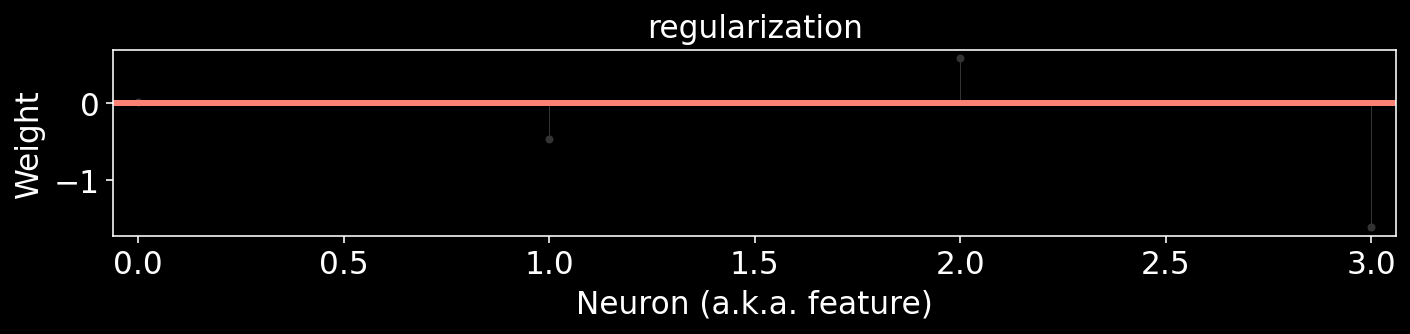

In [20]:
log_reg_l2 = LogisticRegression(penalty="l2", C=0.1).fit(X_test, y_test)

plot_weights({"regularization": log_reg_l2})

In [ ]:
log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
log_reg_l1.fit(X, y)
plot_weights({"regularization": log_reg_l1})

In [ ]:
f, ax = plt.subplots(figsize=(20,10))
ax.plot(ts, lfp[:,0])
for ripple in ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=1000)

## plot some examples

In [ ]:
# pick random ripples to plot
r = np.random.randint(0,len(ripple_times),25)

fig, axs = plt.subplots(5,5, figsize=(20, 20), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()
for i in range(25):
    idx = np.logical_and(ts >= ripple_times.iloc[r[i]].start_time_extended, ts <= ripple_times.iloc[r[i]].end_time_extended)
    axs[i].plot(ts[idx],lfp[idx,int(ripple_times.iloc[r[i]].peak_channel)],linewidth=1)
    axs[i].axis('off') 
#     axs[i].set_title('duration %s' % float('%.2g' % ripple_times.iloc[r[i]].ripple_duration))
    axs[i].set_title('peak_freq %s' % float('%.2g' % ripple_times.iloc[r[i]].peak_freq))

fig, axs = plt.subplots(5,5, figsize=(20, 20), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()        
for i in range(25):
    idx = np.logical_and(ts >= ripple_times.iloc[r[i]].start_time_extended, ts <= ripple_times.iloc[r[i]].end_time_extended)
    axs[i].plot(ts[idx],filtered_lfps[idx,int(ripple_times.iloc[r[i]].peak_channel)],linewidth=1)
    axs[i].axis('off')      

In [ ]:
plt.hist(ripple_times.peak_freq)

In [ ]:
r = np.random.randint(0,len(ripple_times),25)

fig, axs = plt.subplots(5,5, figsize=(20, 20), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)

axs = axs.ravel()

# for i in range(25):
#   idx = np.logical_and(ts >= ripple_times.iloc[r[i]].start_time_extended, ts <= ripple_times.iloc[r[i]].end_time_extended)
#   for j in range(channels):
#       axs[i].plot(ts[idx],filtered_lfps[idx,j],linewidth=1)
#       axs[i].axis('off')
        
        
for i in range(25):
    idx = np.logical_and(ts >= ripple_times.iloc[r[i]].start_time_extended, ts <= ripple_times.iloc[r[i]].end_time_extended)
    axs[i].plot(ts[idx],filtered_lfps[idx,int(ripple_times.iloc[r[i]].peak_channel)],linewidth=1)
    axs[i].axis('off')         